<a href="https://colab.research.google.com/github/Pembo2008/Chat_Bot_for_Medical_Organizations/blob/master/%D0%90%D0%9F%D0%A0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Тестовое задание Южаков Максим (займы физическим лицам)

# Необходимо

1. выполнить анализ и охарактеризовать клиентский портфель организации
2. построить базовую модель прогнозирования банкротства, одобряющую не менее 35% клиентов при банкротстве среди одобренных не выше 15%.
3. подготовить рекомендации и предложения по изменению признакового пространства, использованию внешних данных и иному развитию базовой модели.

#### Импорт и загрузка данных

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.linear_model import LogisticRegression
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_union, make_pipeline
from sklearn.preprocessing import FunctionTransformer, LabelEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from scipy import stats
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn import tree
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
# from catboost import CatBoostClassifier
from sklearn.metrics import log_loss
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer, recall_score
from imblearn.over_sampling import RandomOverSampler

In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
credits = pd.read_csv('/content/drive/MyDrive/test_task/apr/new_training_data_31_08_2022.csv')
reject = pd.read_csv('/content/drive/MyDrive/test_task/apr/all_reject_data.csv')

In [26]:
credits.head()

,Unnamed: 0,age,lastcredit,time_to_lastcredit_closeddt,close_loan_median,open_loan_median,is_active_100,isnt_active_100,is_lost_100,micro_loans_active_100,...,is_active_type_micro_3,is_type_credit_card_1,is_type_consumer_1,is_type_micro_1,is_active_type_credit_card_1,is_active_type_consumer_1,is_active_type_micro_1,overall_worst_overdue_state_12,ratio_sum_outstanding_to_open_sum,target
0,0,43.0,81.0,235.0,0.0,4.0,34.0,70.0,0.0,421478.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,120.0,0.942917,0.0
1,1,35.0,3.0,0.0,0.0,1.0,41.0,36.0,0.0,627578.0,...,33.0,0.0,0.0,20.0,0.0,0.0,14.0,7.0,NaN,0.0
2,2,27.0,19.0,65.0,0.0,7.0,25.0,34.0,0.0,214655.0,...,2.0,0.0,0.0,1.0,0.0,0.0,1.0,120.0,0.098896,1.0
3,3,32.0,14.0,76.0,0.0,11.5,13.0,35.0,0.0,88856.0,...,9.0,0.0,0.0,5.0,0.0,0.0,5.0,59.0,0.298009,1.0
4,5,23.0,5.0,0.0,0.0,1.0,26.0,52.0,0.0,345820.0,...,19.0,0.0,0.0,16.0,0.0,0.0,12.0,29.0,0.031670,0.0


In [27]:
reject.head()

,Unnamed: 0,age,lastcredit,time_to_lastcredit_closeddt,close_loan_median,open_loan_median,is_active_100,isnt_active_100,is_lost_100,micro_loans_active_100,...,is_active_type_consumer_3,is_active_type_micro_3,is_type_credit_card_1,is_type_consumer_1,is_type_micro_1,is_active_type_credit_card_1,is_active_type_consumer_1,is_active_type_micro_1,overall_worst_overdue_state_12,ratio_sum_outstanding_to_open_sum
0,4,35.0,903.0,44683.0,0.0,43335.0,3.0,0.0,0.0,3500.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.056551
1,6,32.0,4.0,0.0,0.0,1.0,31.0,361.0,0.0,403828.0,...,0.0,16.0,0.0,0.0,35.0,0.0,0.0,14.0,0.0,NaN
2,9,25.0,17.0,0.0,0.0,1.0,31.0,29.0,0.0,401027.0,...,0.0,30.0,0.0,0.0,1.0,0.0,0.0,1.0,59.0,0.557095
3,10,42.0,2.0,0.0,0.0,1.0,38.0,206.0,0.0,844402.0,...,0.0,26.0,0.0,0.0,12.0,0.0,0.0,11.0,29.0,0.092473
4,12,38.0,204.0,73.0,0.0,1.0,39.0,98.0,0.0,600680.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,59.0,0.084674


In [28]:
credits.shape

(42529, 75)

In [29]:
reject.shape

(106511, 74)

#### Очистка

In [30]:
credits = credits.drop(['overdue_loans_12','overdue_loans_3','ratio_overdue_loans_3_to_12'],axis=1)
reject = reject.drop(['overdue_loans_12','overdue_loans_3','ratio_overdue_loans_3_to_12'],axis=1)

In [31]:
credits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42529 entries, 0 to 42528
Data columns (total 72 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Unnamed: 0                            42529 non-null  int64  
 1   age                                   42529 non-null  float64
 2   lastcredit                            42529 non-null  float64
 3   time_to_lastcredit_closeddt           42529 non-null  float64
 4   close_loan_median                     42520 non-null  float64
 5   open_loan_median                      42520 non-null  float64
 6   is_active_100                         42529 non-null  float64
 7   isnt_active_100                       42529 non-null  float64
 8   is_lost_100                           42529 non-null  float64
 9   micro_loans_active_100                42529 non-null  float64
 10  is_active_12                          42529 non-null  float64
 11  open_sum_12    

In [32]:
credits = credits.rename(columns={'Unnamed: 0':'id'})
reject = reject.rename(columns={'Unnamed: 0':'id'})

Для анализа объединим вообще все данные

Для обучения моделей смерджим таблицы по id пользователя (оставим только тех, по которым есть target)

In [33]:
reject['rejection'] = 1 #признак отказа в займе
credits['rejection'] = 0

In [34]:
credits.head()

,id,age,lastcredit,time_to_lastcredit_closeddt,close_loan_median,open_loan_median,is_active_100,isnt_active_100,is_lost_100,micro_loans_active_100,...,is_type_credit_card_1,is_type_consumer_1,is_type_micro_1,is_active_type_credit_card_1,is_active_type_consumer_1,is_active_type_micro_1,overall_worst_overdue_state_12,ratio_sum_outstanding_to_open_sum,target,rejection
0,0,43.0,81.0,235.0,0.0,4.0,34.0,70.0,0.0,421478.0,...,0.0,0.0,0.0,0.0,0.0,0.0,120.0,0.942917,0.0,0
1,1,35.0,3.0,0.0,0.0,1.0,41.0,36.0,0.0,627578.0,...,0.0,0.0,20.0,0.0,0.0,14.0,7.0,NaN,0.0,0
2,2,27.0,19.0,65.0,0.0,7.0,25.0,34.0,0.0,214655.0,...,0.0,0.0,1.0,0.0,0.0,1.0,120.0,0.098896,1.0,0
3,3,32.0,14.0,76.0,0.0,11.5,13.0,35.0,0.0,88856.0,...,0.0,0.0,5.0,0.0,0.0,5.0,59.0,0.298009,1.0,0
4,5,23.0,5.0,0.0,0.0,1.0,26.0,52.0,0.0,345820.0,...,0.0,0.0,16.0,0.0,0.0,12.0,29.0,0.031670,0.0,0


таблица для обучения модели:

In [35]:
tmp_reject = pd.merge(reject, credits[['id', 'target']], how = 'inner', on = ['id'])
df = pd.concat([credits,tmp_reject])

In [36]:
for i in df.columns:
    df[i] = df[i].fillna(df[i].mean())

In [37]:
df.replace([np.inf, -np.inf], 0, inplace=True)

In [38]:
credits.age = credits.age.astype('int')

Таблица для аналитики:

In [39]:
tmp_reject_2 = reject.copy()
tmp_reject_2['target'] = 0

In [40]:
tmp_reject_2.shape

(106511, 73)

In [41]:
data = pd.concat([tmp_reject_2,credits])

In [42]:
for i in data.columns:
    data[i] = data[i].fillna(data[i].mean())

In [43]:
data.shape

(149040, 73)

#### Анализ

Напомню, что для анализа используются вообще все данные

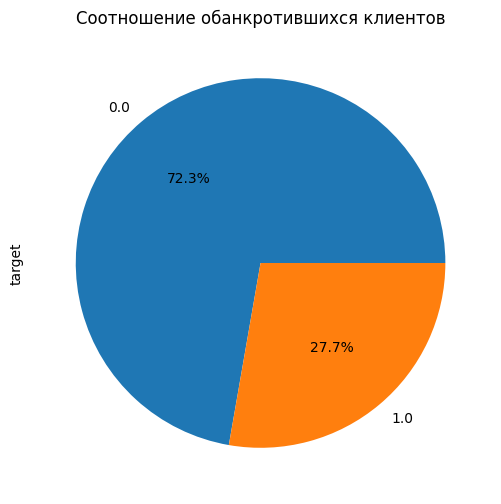

In [ ]:
plt.figure(figsize=(6, 6))
credits['target'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Соотношение обанкротившихся клиентов')
plt.show()

Около 27% клиентов, которым выдаются займы - обонкрачиваются

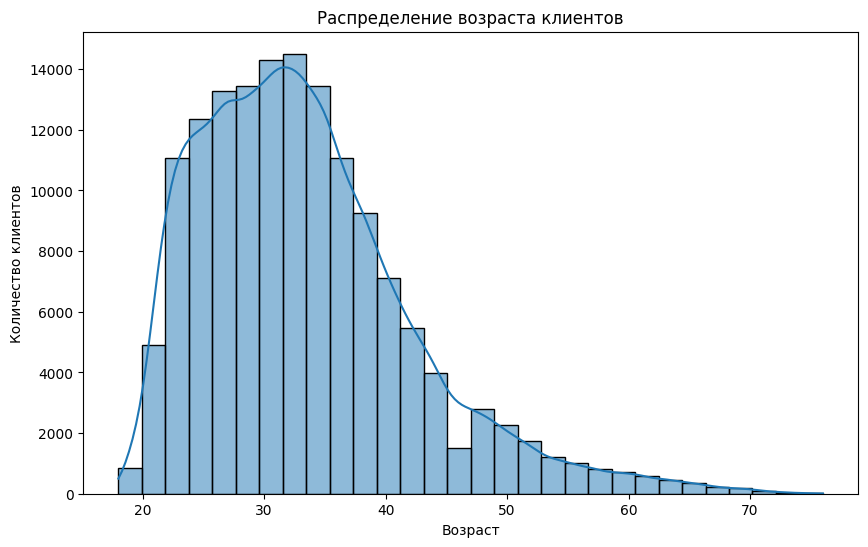

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(data['age'], bins=30, kde=True)
plt.title("Распределение возраста клиентов")
plt.xlabel("Возраст")
plt.ylabel("Количество клиентов")
plt.show()

В среднем заемщики - лица от 20 до 45 лет, причем количество банкротств пропорцианально


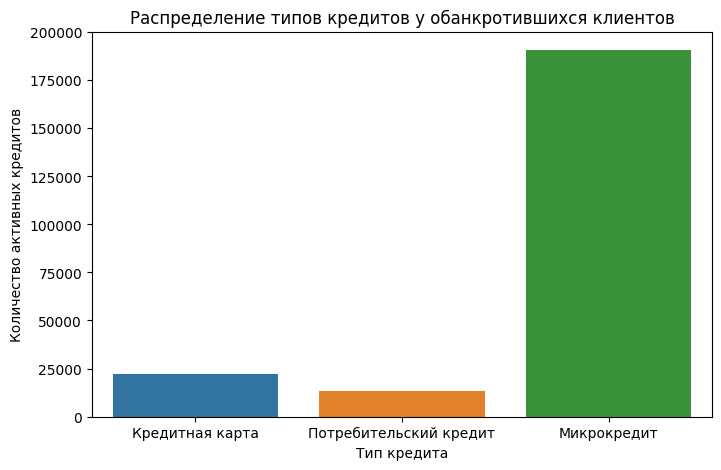

In [ ]:
bankrupt_clients = data[data['target'] == 1]

# График распределения типов кредитов у обанкротившихся клиентов
plt.figure(figsize=(8, 5))
sns.barplot(x=['Кредитная карта', 'Потребительский кредит', 'Микрокредит'],
            y=[bankrupt_clients['is_active_type_credit_card_100'].sum(),
               bankrupt_clients['is_active_type_consumer_100'].sum(),
               bankrupt_clients['is_active_type_micro_100'].sum()])
plt.xlabel('Тип кредита')
plt.ylabel('Количество активных кредитов')
plt.title('Распределение типов кредитов у обанкротившихся клиентов')
plt.show()

Судя по всему микрокредиты - самая частая причина банкротств, так как у обанкротившихся заемщиков очень много активных микрокредитов

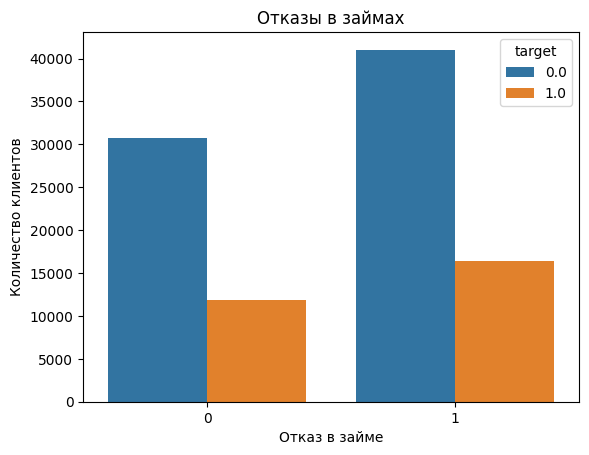

In [ ]:
sns.countplot(x='rejection', hue='target', data=df)
plt.title('Отказы в займах')
plt.xlabel('Отказ в займе')
plt.ylabel('Количество клиентов')
plt.show()

Вероятно, у лиц, подающих наибольшее количество заявок, чаще всего случаются банкротства

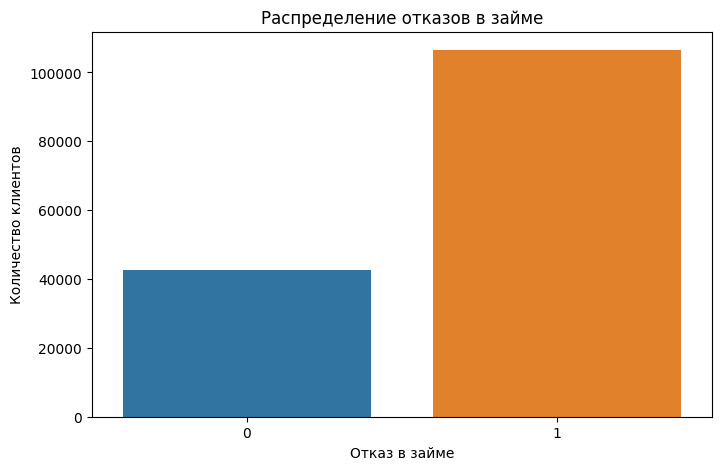

In [ ]:
plt.figure(figsize=(8, 5))
sns.countplot(x='rejection', data=data)
plt.xlabel('Отказ в займе')
plt.ylabel('Количество клиентов')
plt.title('Распределение отказов в займе')
plt.show()

Отказов в займе значительно больше, чем принятых заявок

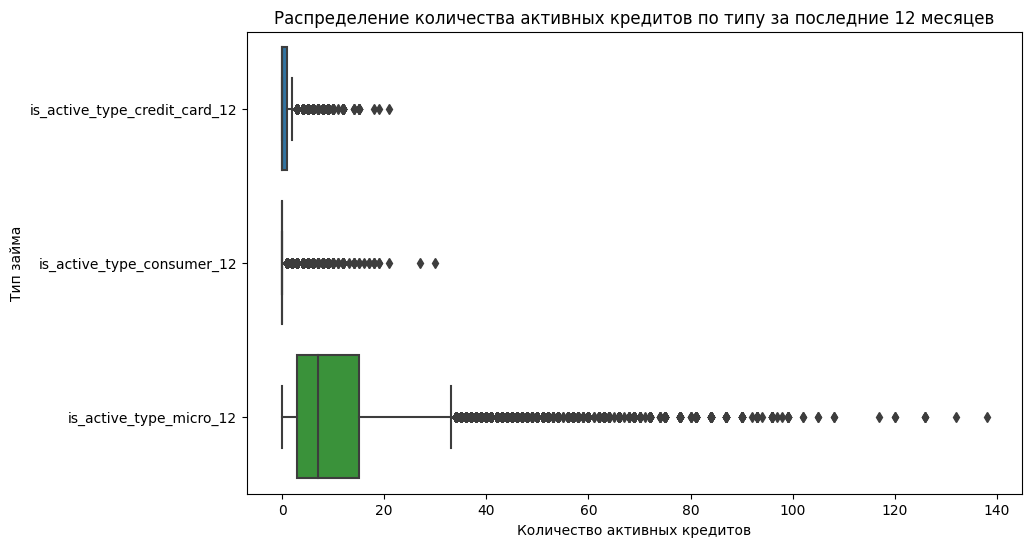

In [ ]:
active_credits_12 = data[['is_active_type_credit_card_12', 'is_active_type_consumer_12', 'is_active_type_micro_12']]
plt.figure(figsize=(10, 6))
sns.boxplot(data=active_credits_12, orient='h')
plt.xlabel('Количество активных кредитов')
plt.ylabel('Тип займа')
plt.title('Распределение количества активных кредитов по типу за последние 12 месяцев')
plt.show()

Микрокредиты - самый популярный вид займов среди активных заявок

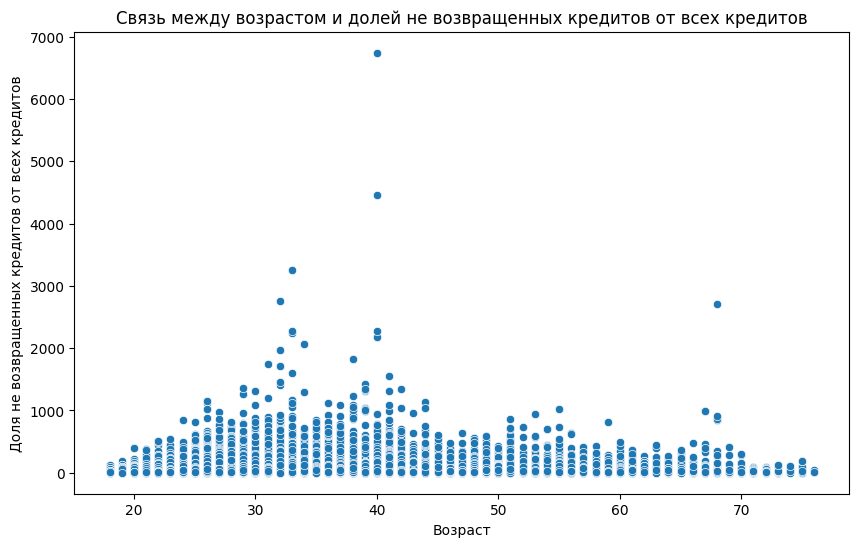

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='age', y='isnt_active_100', data=data)
plt.xlabel('Возраст')
plt.ylabel('Доля не возвращенных кредитов от всех кредитов')
plt.title('Связь между возрастом и долей не возвращенных кредитов от всех кредитов')
plt.show()

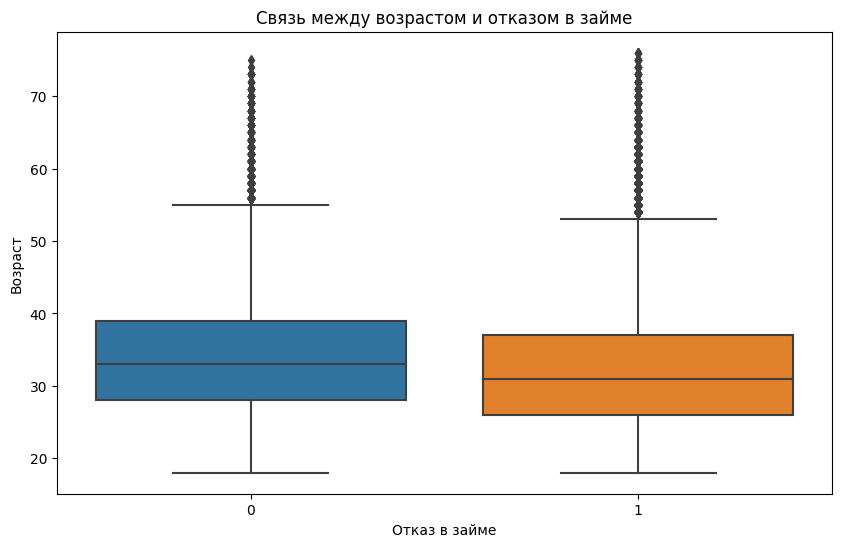

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='rejection', y='age', data=data)
plt.xlabel('Отказ в займе')
plt.ylabel('Возраст')
plt.title('Связь между возрастом и отказом в займе')
plt.show()

Возможно, чуть более молодым чаще отказывают в займе

Итого:


*   Около 27% клиентов, которым выдаются займы - обонкрачиваются
*   В среднем заемщики - лица от 20 до 45 лет, причем количество банкротств пропорцианально
*   Судя по всему микрокредиты - самая частая причина банкротств, так как у обанкротившихся заемщиков очень много активных микрокредитов
*   Вероятно, у лиц, подающих наибольшее количество заявок, чаще всего случаются банкротства
*   Микрокредиты - самый популярный вид займов
*   Отказов в займе значительно больше, чем принятых заявок
*   Возможно, чуть более молодым чаще отказывают в займе


#### Обучение моделей

Построить базовую модель прогнозирования банкротства, одобряющую не менее 35% клиентов при банкротстве среди одобренных не выше 15%.

В результате recall по 1 классу(банкротство) должен быть более 0.85, а количество предсказаний 0-го класса не менее 35%

In [37]:
# df_tmp = df.copy()

In [38]:
# df['ratio_pattern_len_to_pattern_1'] = df['ratio_pattern_len_to_pattern_1']*df['ratio_pattern_len_to_pattern_2']*df['ratio_pattern_len_to_pattern_3']*df['ratio_pattern_len_to_pattern_4']
# df['is_active_type_credit_card_100'] = df['is_active_type_credit_card_100']*df['is_active_type_credit_card_1']*df['is_active_type_credit_card_3']*df['is_active_type_credit_card_12']
# df['is_type_consumer_100'] = df['is_type_consumer_100']*df['is_type_consumer_1']*df['is_type_consumer_3']*df['is_type_consumer_12']
# df['is_type_micro_100'] = df['is_type_micro_100']*df['is_type_micro_1']*df['is_type_micro_3']*df['is_type_micro_12']
# df['is_type_credit_card_100'] = df['is_type_credit_card_100']*df['is_type_credit_card_1']*df['is_type_credit_card_3']*df['is_type_credit_card_12']*df['is_type_credit_card_100']
# df['is_active_type_consumer_100'] = df['is_active_type_consumer_100']*df['is_active_type_consumer_1']*df['is_active_type_consumer_3']*df['is_active_type_consumer_12']
# df['is_active_type_micro_100'] = df['is_active_type_micro_100']*df['is_active_type_micro_1']*df['is_active_type_micro_3']*df['is_active_type_micro_12']
# df['is_active_100'] = df['is_active_100']*df['is_active_1']*df['is_active_3']*df['is_active_12']*df['is_active_type_micro_100']
# df['is_lost_100'] = df['is_lost_100']*df['is_lost_1']*df['is_lost_3']*df['is_lost_12']
# df['open_sum_12'] = df['open_sum_1']*df['open_sum_3']*df['open_sum_12']
# df['isnt_active_100'] = df['isnt_active_100']*df['isnt_active_1']*df['isnt_active_3']*df['isnt_active_12']
# df['micro_loans_active_100'] = df['micro_loans_active_100']*df['micro_loans_active_1']*df['micro_loans_active_3']*df['micro_loans_active_12']
# df['ratio_history_100'] = df['ratio_history_100']*df['ratio_history_1']*df['ratio_history_3']*df['ratio_history_12']
# df['fraction_last_x_12'] = df['fraction_last_x_1']*df['fraction_last_x_3']*df['fraction_last_x_12']
# df['mean_delay_100_with_lag'] = df['mean_delay_12_with_lag']*df['mean_delay_1_with_lag']*df['mean_delay_3_with_lag']*df['mean_delay_100_with_lag']
# df = df.drop(['ratio_pattern_len_to_pattern_2','ratio_pattern_len_to_pattern_3','ratio_pattern_len_to_pattern_4','is_active_type_credit_card_1','is_active_type_credit_card_12',
#          'is_active_type_credit_card_3','is_type_consumer_1','is_type_consumer_3','is_type_consumer_12','is_type_micro_1','is_type_micro_3','is_type_micro_12',
#          'is_active_type_credit_card_1','is_active_type_credit_card_12','is_active_type_credit_card_3','is_type_credit_card_1','is_type_credit_card_3','is_type_credit_card_12',
#          'is_active_type_consumer_1','is_active_type_consumer_3','is_active_type_consumer_12','is_active_type_micro_1','is_active_type_micro_3','is_active_type_micro_12',
#          'is_active_1','is_active_3','is_active_12','is_lost_1','is_lost_12','is_lost_3','open_sum_1','open_sum_3','isnt_active_1','isnt_active_3','isnt_active_12',
#          'micro_loans_active_1','micro_loans_active_3','micro_loans_active_12','ratio_history_1','ratio_history_12','ratio_history_3','fraction_last_x_1','fraction_last_x_3',
#          'mean_delay_12_with_lag','mean_delay_1_with_lag','mean_delay_3_with_lag','is_active_type_micro_100','id'],axis=1)

In [39]:
# corr_matrix = df.corr()
# plt.figure(figsize=(18, 12))
# sns.heatmap(corr_matrix, annot=True, fmt=".1f", linewidths=.9, cmap=sns.light_palette("purple"))

Очень много скоррелированных пременных - было решено использовать REF метод

In [40]:
# df.shape

In [44]:
for i in df.columns:
    df[i] = df[i].fillna(df[i].mean())

In [42]:
# for i in df_tmp.columns:
#     df_tmp[i] = df_tmp[i].fillna(df_tmp[i].mean())

In [43]:
# df_normalized = df.copy()

In [44]:
# tmp = df_normalized.loc[:,df_normalized.columns!='target']

In [45]:
# mm = MinMaxScaler()
# df_normalized.loc[:,df_normalized.columns!='target'] = mm.fit_transform(tmp)
# mm = StandardScaler()
# df_normalized.loc[:,df_normalized.columns!='target'] = mm.fit_transform(tmp)

In [46]:
# X = df_normalized.drop('target', axis=1)
# y = df_normalized['target']

Oversampling сработал не лучше установки определенного class_weight, поэтому его решил не использовать

In [45]:
oversampler = RandomOverSampler(sampling_strategy='minority')
# X_resampled, y_resampled = oversampler.fit_resample(X_train, y_train)
scorer = make_scorer(recall_score, pos_label=1)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)

Logistic Regression

In [48]:
from sklearn.feature_selection import RFE
from sklearn.metrics import recall_score, confusion_matrix
X = df.drop('target', axis=1)
y = df['target']
# Разделим данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Стандартизируем данные
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Отберем наиболее информативные признаки с помощью RFE
model = LogisticRegression(penalty = 'l2',solver='lbfgs',class_weight = {0:0.28,1:0.72})
rfe = RFE(model, n_features_to_select=30)
X_train_selected = rfe.fit_transform(X_train_scaled, y_train)
X_test_selected = rfe.transform(X_test_scaled)

# Обучим модель логистической регрессии
lr = LogisticRegression(penalty = 'l2',solver='lbfgs',class_weight = {0:0.28,1:0.72})
param_grid = {'C': [0.1,0.5,1,10,50,100],
              'tol':[0.00001,0.0001,0.000001]}
lr_grid = GridSearchCV(lr,param_grid,cv=skf,scoring=scorer)
lr_grid.fit(X_train_scaled,y_train)
# model.fit(X_train_selected, y_train)

# Оценим качество модели на тестовой выборке
y_pred = lr_grid.predict(X_test_scaled)
recall = recall_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
percent_class_0 = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1] + conf_matrix[1, 0] + conf_matrix[1, 1])

print("Recall для класса 1:", recall)
print("Количество предсказаний 0-го класса в процентах:", percent_class_0 * 100)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Recall для класса 1: 0.5801173750666904
Количество предсказаний 0-го класса в процентах: 35.74180635476608


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [49]:
print("Recall для класса 1:", recall)
print("Количество предсказаний 0-го класса в процентах:", percent_class_0 * 100)

Recall для класса 1: 0.5801173750666904
Количество предсказаний 0-го класса в процентах: 35.74180635476608


In [50]:
print(classification_report(y_test, lr_grid.predict(X_test_scaled)))

              precision    recall  f1-score   support

         0.0       0.75      0.50      0.60     14362
         1.0       0.31      0.58      0.41      5623

    accuracy                           0.52     19985
   macro avg       0.53      0.54      0.50     19985
weighted avg       0.63      0.52      0.54     19985



In [57]:
X.shape

(99921, 72)

In [24]:
X = df.drop('target', axis=1)
y = df['target']
# Разделим данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Стандартизируем данные
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Отберем наиболее информативные признаки с помощью RFE
model = RandomForestClassifier(random_state=17,class_weight = {0:0.28,1:0.72})
rfe = RFE(model, n_features_to_select=30)
X_train_selected = rfe.fit_transform(X_train_scaled, y_train)
X_test_selected = rfe.transform(X_test_scaled)

# Обучим модель логистической регрессии
rf_params = {
        'n_estimators':  [50,100],
        'min_samples_split': [3, 4, 5,7],
        'max_depth': [3, 5, 6, 7, 8],
        'max_features': [2,4,6,7,8,9]
        }
rf = RandomizedSearchCV(RandomForestClassifier(random_state=17,class_weight = {0:0.28,1:0.72}),
                                 rf_params,cv=skf, n_jobs=-1,scoring=scorer)
rf.fit(X_train_selected,y_train)

# Оценим качество модели на тестовой выборке
y_pred = rf.predict(X_test_selected)
recall = recall_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
percent_class_0 = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1] + conf_matrix[1, 0] + conf_matrix[1, 1])

print("Recall для класса 1:", recall)
print("Количество предсказаний 0-го класса в процентах:", percent_class_0 * 100)

Recall для класса 1: 0.6151520540636671
Количество предсказаний 0-го класса в процентах: 33.64023017262947


In [25]:
print("Recall для класса 1:", recall)
print("Количество предсказаний 0-го класса в процентах:", percent_class_0 * 100)

Recall для класса 1: 0.6151520540636671
Количество предсказаний 0-го класса в процентах: 33.64023017262947


In [27]:
X = df.drop('target', axis=1)
y = df['target']
# Разделим данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Стандартизируем данные
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Отберем наиболее информативные признаки с помощью RFE
model = XGBClassifier(random_state=17,class_weight = {0:0.28,1:0.72})
rfe = RFE(model, n_features_to_select=30)
X_train_selected = rfe.fit_transform(X_train_scaled, y_train)
X_test_selected = rfe.transform(X_test_scaled)

# Обучим модель логистической регрессии
xg_params = {
        'n_estimators': [100,200,500,1000],
        'min_child_weight': [1, 5, 10],
        'max_depth': [5,6,7,8],
        'gamma': [0.01,0.001,0.001]
        }
xg = RandomizedSearchCV(XGBClassifier(random_state=17,class_weight = {0:0.28,1:0.72}),
                                 xg_params,cv=skf, n_jobs=-1,scoring=scorer)
xg.fit(X_train_selected,y_train)

# Оценим качество модели на тестовой выборке
y_pred = rf.predict(X_test_selected)
recall = recall_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
percent_class_0 = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1] + conf_matrix[1, 0] + conf_matrix[1, 1])

print("Recall для класса 1:", recall)
print("Количество предсказаний 0-го класса в процентах:", percent_class_0 * 100)

[02:19:57] WARNING: ../src/learner.cc:767: 
Parameters: { "class_weight" } are not used.

[02:20:48] WARNING: ../src/learner.cc:767: 
Parameters: { "class_weight" } are not used.

[02:21:30] WARNING: ../src/learner.cc:767: 
Parameters: { "class_weight" } are not used.

[02:22:16] WARNING: ../src/learner.cc:767: 
Parameters: { "class_weight" } are not used.

[02:22:58] WARNING: ../src/learner.cc:767: 
Parameters: { "class_weight" } are not used.

[02:23:43] WARNING: ../src/learner.cc:767: 
Parameters: { "class_weight" } are not used.

[02:24:23] WARNING: ../src/learner.cc:767: 
Parameters: { "class_weight" } are not used.

[02:25:09] WARNING: ../src/learner.cc:767: 
Parameters: { "class_weight" } are not used.

[02:25:51] WARNING: ../src/learner.cc:767: 
Parameters: { "class_weight" } are not used.

[02:26:32] WARNING: ../src/learner.cc:767: 
Parameters: { "class_weight" } are not used.

[02:27:11] WARNING: ../src/learner.cc:767: 
Parameters: { "class_weight" } are not used.

[02:27:55]

Из-за долгих вычисление другие гиперпараметры потестить не удалось, лучшая модель Logistic Regression - Recall ~ 0.6, 0 класс - 35% предсказаний

**По поводу рекомендаций по изменению признакового пространстова:**

1) Есть проблема с корреляцией ценных признаков, которые жалко перемножать или выкидывать. В первую очередь есть идея заменить признаки, отражающие лаги 1/3/12/100(за все время) мсяцы, на один признак, вероятно, можно взять отношение к месячной задолженности относительно текущего периода (все в зависимости от признака). Либо скомбинировать признаки иным способом

2) Можно добавить больше "демографических" признаков, если это возможно, как правило это часто дает большой вклад в результаты предсказаний модели

3) Можно сделать отдельные таблицы для каждого типа займов и если объем данных позволяет - сделать 3 разные модели

4) Среди внешних данных можно использовать крусы валют, ситуацию на рынке или данные о доходе/регионе заемщика

и т.д можно достать очень много признаков и потом почистить не очень ценные

**Модель**

1) Что касается развития модели, вероятно, можно попробровать использование стекинга из нескольких моделей. Так же можно попробовать использовать полносвязную сеть, но она у меня тут показала скор не лучше, чем лог регрессия.

2) Использовать более длинный временной период

3) Можно попробовать увеличить объем данных, балансировку классов(oversampling), на моих моделях он показал себя не очень, но на других может дать лучший эффект